In [117]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

plt.style.use('ggplot')

sys.path.append('/home/mitch/school/data/mexico_enigh/')
import src.utils as utils
import src.json_utils

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
dicts = '/home/mitch/github/ENIGH/dicts/'
#sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
os.chdir(processed)
df = pd.read_csv('data.csv')


In [118]:
df.location.astype(str).apply(lambda x : x[:2]).value_counts().sort_index()

location
1     1105
10     535
11    1159
12     535
13    1103
14    1322
15    2005
16     528
17     487
18     496
19     748
2      466
20    1044
21    1188
22     519
23     480
24     511
25     554
26     530
27    1218
28     492
29     563
3      470
30    1272
31     509
32     528
4     1076
5     1744
6      467
7      557
8      543
9     2103
Name: count, dtype: int64

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26857 entries, 0 to 26856
Data columns (total 92 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_current                                      26857 non-null  float64
 1   income_business                                          26857 non-null  float64
 2   location_size                                            26857 non-null  int64  
 3   consumption_health                                       26857 non-null  float64
 4   income_salary                                            26857 non-null  float64
 5   income_transfers                                         26857 non-null  float64
 6   consumption_food                                         26857 non-null  float64
 7   consumption_total                                        26857 non-null  float64
 8   income_total              

In [120]:
df['post'] = df['Y'] == 1996
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [121]:
df = (df.query('income > 0')
      .query('consumption > 0')
      .query('age >= 25')
      .query('age <= 60'))
#df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

df['year_weight'] = df.groupby('Y')['weight'].transform(np.sum) / df['weight'].sum()

/tmp/ipykernel_68512/4039516401.py:7: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df['year_weight'] = df.groupby('Y')['weight'].transform(np.sum) / df['weight'].sum()


In [122]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20448


/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)


In [123]:
expense_labels = src.json_utils.load_json(dicts + 'expense_labels.json')
expense_labels

{'has_expense_credit_card_payments': 'Credit Card',
 'has_expense_debt_to_work_or_person': 'Debts',
 'has_expense_deposits_savings': 'Deposits / Savings',
 'has_expense_foreigncurrencies_perciousmetals_art': 'Foreign Currencies/ Precious Metals/ Art',
 'has_expense_hhbusiness_machinery_animal_equipment': 'Business: Machinary/ Animal/ Equipment',
 'has_expense_hhbusiness_negative_balance': 'Business: Negative balance',
 'has_expense_life_insurance': 'Life Insurance',
 'has_expense_loans_to_third_parties': 'Loans to Others',
 'has_expense_other': 'Other',
 'has_expense_realestate_hh_inhabit': 'Real Estate (Inhabited)',
 'has_expense_realestate_hh_not_inhabit': 'Real Estate (Not Inhabited)',
 'has_expense_realestate_mortgage': 'Real Estate (Mortgage)',
 'has_expense_securities_shares_bond': 'Securities / Bonds',
 'has_expense_trademarks_patents_copyrights': 'Trademarks / Patents / Copyrights',
 'has_expense_inheritance_dowrie_legacies': 'Inheritance / Dowrie / Legacy',
 'has_income_coins_

In [124]:
df

,consumption_current,income_business,location_size,consumption_health,income_salary,income_transfers,consumption_food,consumption_total,income_total,income_current,...,has_income_rental_trademarks_patents_copyrights,has_income_securities_bonds,has_income_withdrawal_savings,post,income,log_income,consumption,log_consumption,year_weight,decile
0,34.000119,0.000000,1,0.059672,36.826188,0.00000,5.867128,43.547649,51.603890,42.056359,...,0.0,0.0,0.0,False,36.826188,3.606209,12.826595,2.551521,0.484181,5
1,44.265249,0.000000,1,0.085246,47.055685,0.00000,17.903154,44.265249,57.175044,57.175044,...,0.0,0.0,0.0,False,47.055685,3.851332,24.818805,3.211602,0.484181,6
2,55.064614,0.000000,1,0.356327,41.429462,14.83277,12.873225,62.225261,69.337660,69.337660,...,0.0,0.0,0.0,False,56.262232,4.030023,23.500223,3.157010,0.484181,6
3,55.399681,15.344245,1,1.193782,61.990750,0.00000,20.684452,67.675077,92.738469,90.692570,...,0.0,0.0,1.0,False,77.334995,4.348147,22.068809,3.094165,0.484181,8
4,122.300197,38.360613,1,0.000000,72.458935,0.00000,35.560885,149.621478,142.232968,137.970678,...,0.0,0.0,1.0,False,110.819548,4.707903,58.902636,4.075886,0.484181,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20443,31.639798,0.000000,1,0.000000,33.833325,0.00000,14.840565,31.639798,35.994922,35.994922,...,0.0,0.0,0.0,True,33.833325,3.521446,17.261058,2.848453,0.515819,5
20444,25.491084,20.793398,1,0.042785,0.000000,0.00000,8.360638,25.554874,29.655967,29.655967,...,0.0,0.0,0.0,True,20.793398,3.034636,9.475728,2.248734,0.515819,3
20445,11.946668,0.000000,1,0.201993,10.673609,0.00000,3.824656,13.054307,15.184759,14.379203,...,0.0,0.0,0.0,True,10.673609,2.367774,5.710783,1.742356,0.515819,1
20446,89.016606,0.000000,2,0.950153,49.622210,0.00000,18.984631,89.016606,88.257518,83.558445,...,0.0,0.0,0.0,True,49.622210,3.904439,38.139556,3.641252,0.515819,7


In [125]:
get_average = [x for x in df.columns if ('has_expense' in x)]
averages = pd.DataFrame(index=get_average)

averages['percent'] = [
    100 * np.average(df[x], axis=0, weights=df['year_weight'] * df['weight'])
    for x in get_average
]
averages = averages.sort_values('percent', ascending=False)
df['has_expense_any'] = (df[get_average].astype(int).sum(axis=1) > 0) + 0
averages

,percent
has_expense_deposits_savings,31.554588
has_expense_credit_card_payments,8.742316
has_expense_debt_to_work_or_person,7.829988
has_expense_hhbusiness_negative_balance,3.953951
has_expense_loans_to_third_parties,3.088302
has_expense_foreigncurrencies_perciousmetals_art,1.110872
has_expense_hhbusiness_machinery_animal_equipment,1.000615
has_expense_life_insurance,0.899553
has_expense_realestate_hh_not_inhabit,0.819669
has_expense_realestate_hh_inhabit,0.396481


Text(0.5, 1.0, 'Financial Expenses')

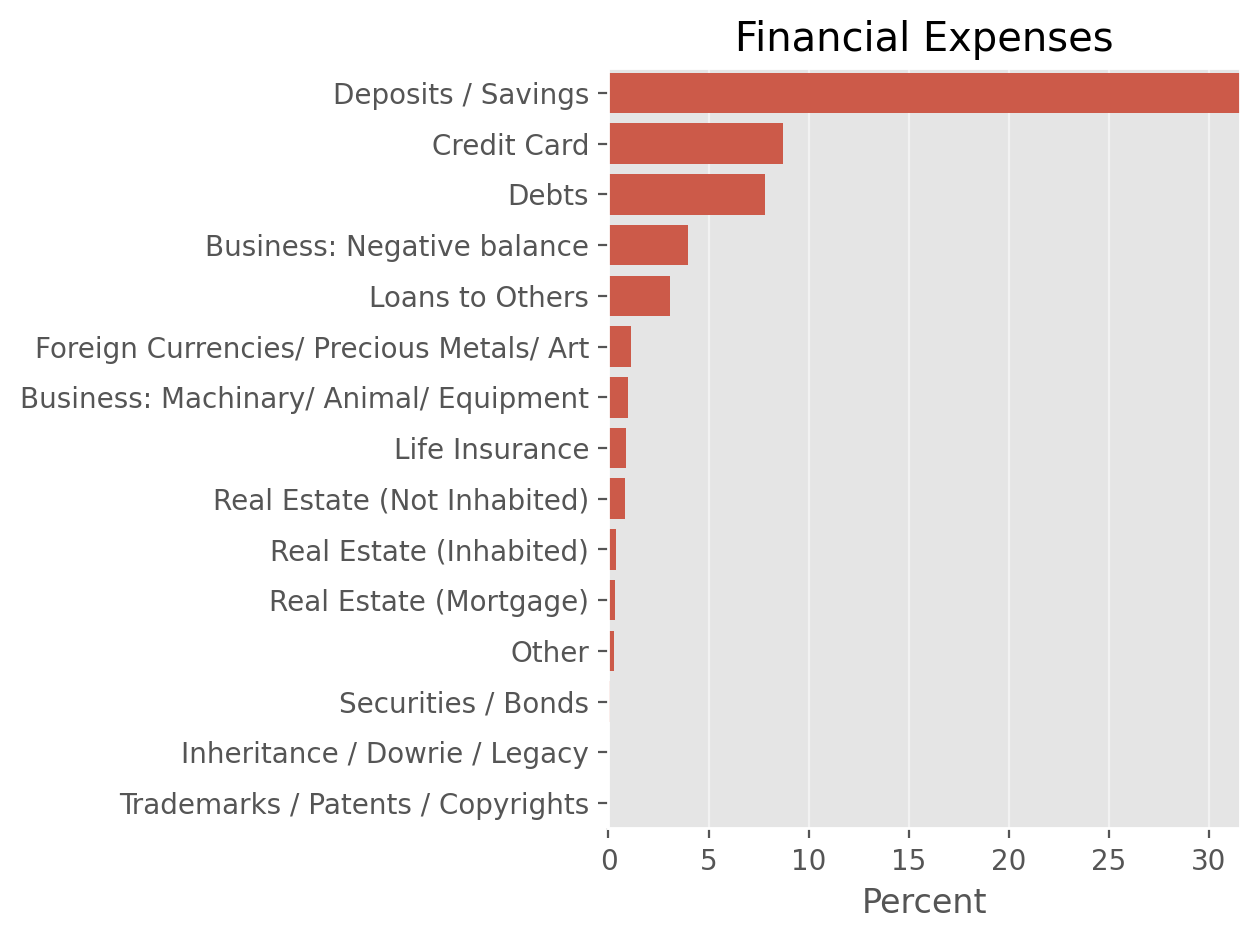

In [126]:
labels = [expense_labels[x] for x in averages.index.values]
sns.barplot(y = labels , x= averages['percent'], 
            orient='h')
plt.xlabel('Percent')
plt.title('Financial Expenses')

In [127]:
get_average = [x for x in df.columns if ('has_income' in x)]
averages = pd.DataFrame(index=get_average)

averages['percent'] = [
    100 * np.average(df[x], axis=0, weights=df['year_weight'] * df['weight'])
    for x in get_average
]
averages = averages.sort_values('percent', ascending=False)
df['has_income_any'] = (df[get_average].sum(axis=1) > 0) + 0
averages

,percent
has_income_from_loans_to_third_parties_not_in_household,8.405681
has_income_withdrawal_savings,6.446036
has_income_coins_preciousmetals_art,5.253136
has_income_from_loans_to_institutions_not_mortgage,4.243090
has_income_rental_houses_buildings_other_realestate,1.553155
has_income_interest_savings_accounts,0.483912
has_income_land_landrental,0.421460
has_income_interest_fixed_investments,0.344793
has_income_hhbusiness_machinery_animal_equipment,0.230951
has_income_house_land_condiminum,0.230496


Text(0.5, 0, 'Percent')

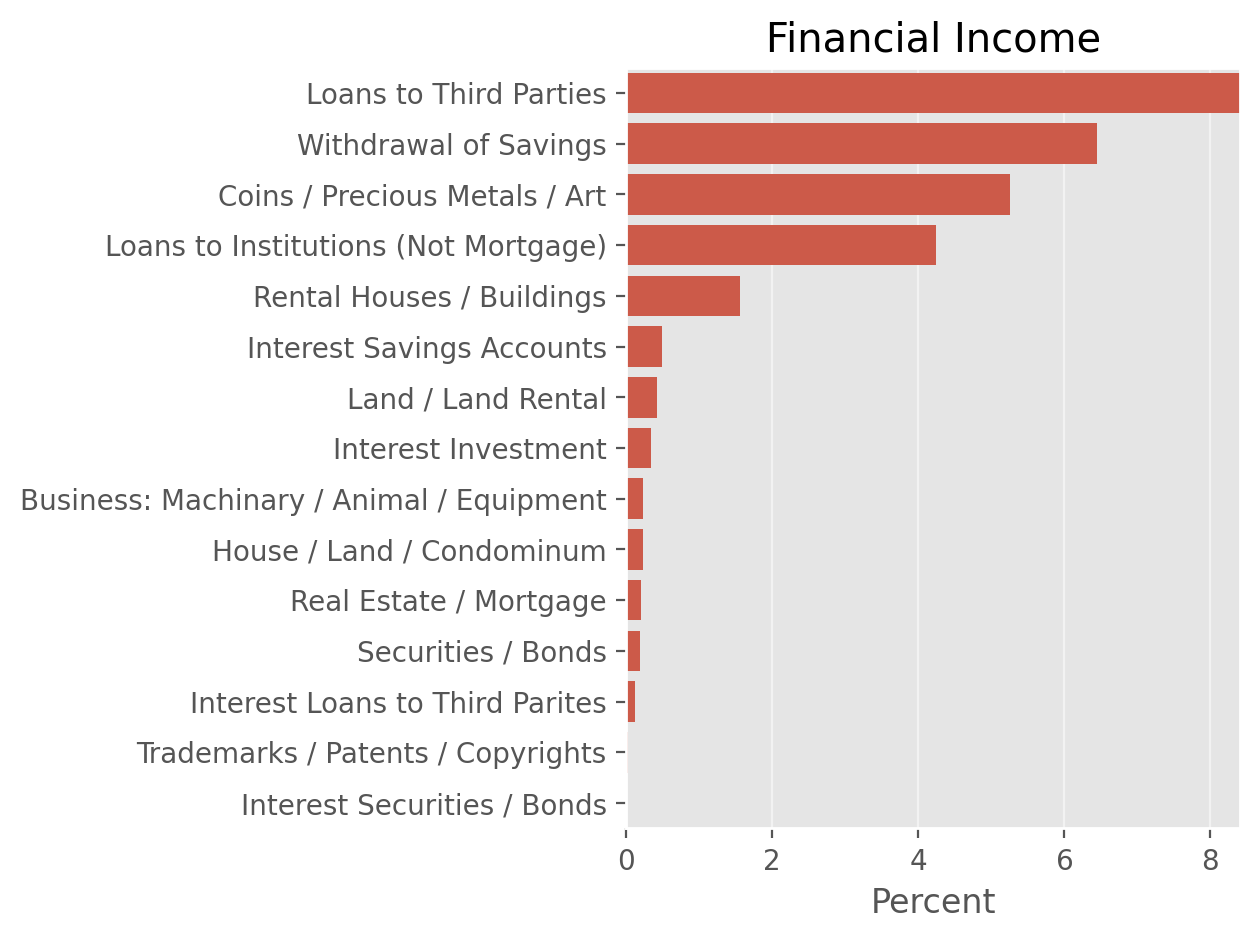

In [128]:
labels = [expense_labels[x] for x in averages.index.values]
sns.barplot(y = labels , x= averages['percent'], 
            orient='h')
plt.title('Financial Income')

plt.xlabel('Percent')

<Axes: xlabel='decile', ylabel='percent'>

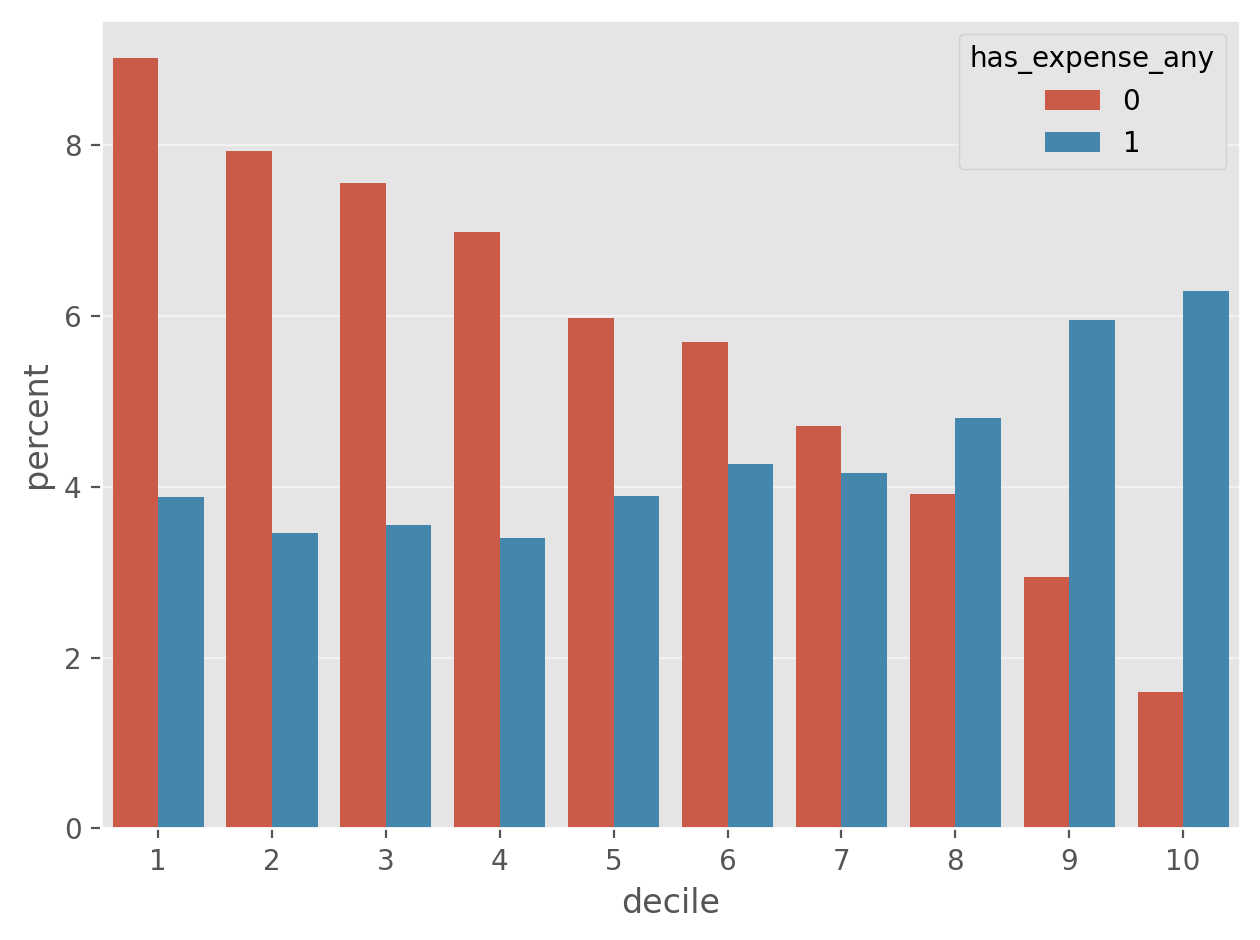

In [129]:
sns.countplot(df, x='decile', hue='has_expense_any', stat='percent')

<Axes: xlabel='education', ylabel='percent'>

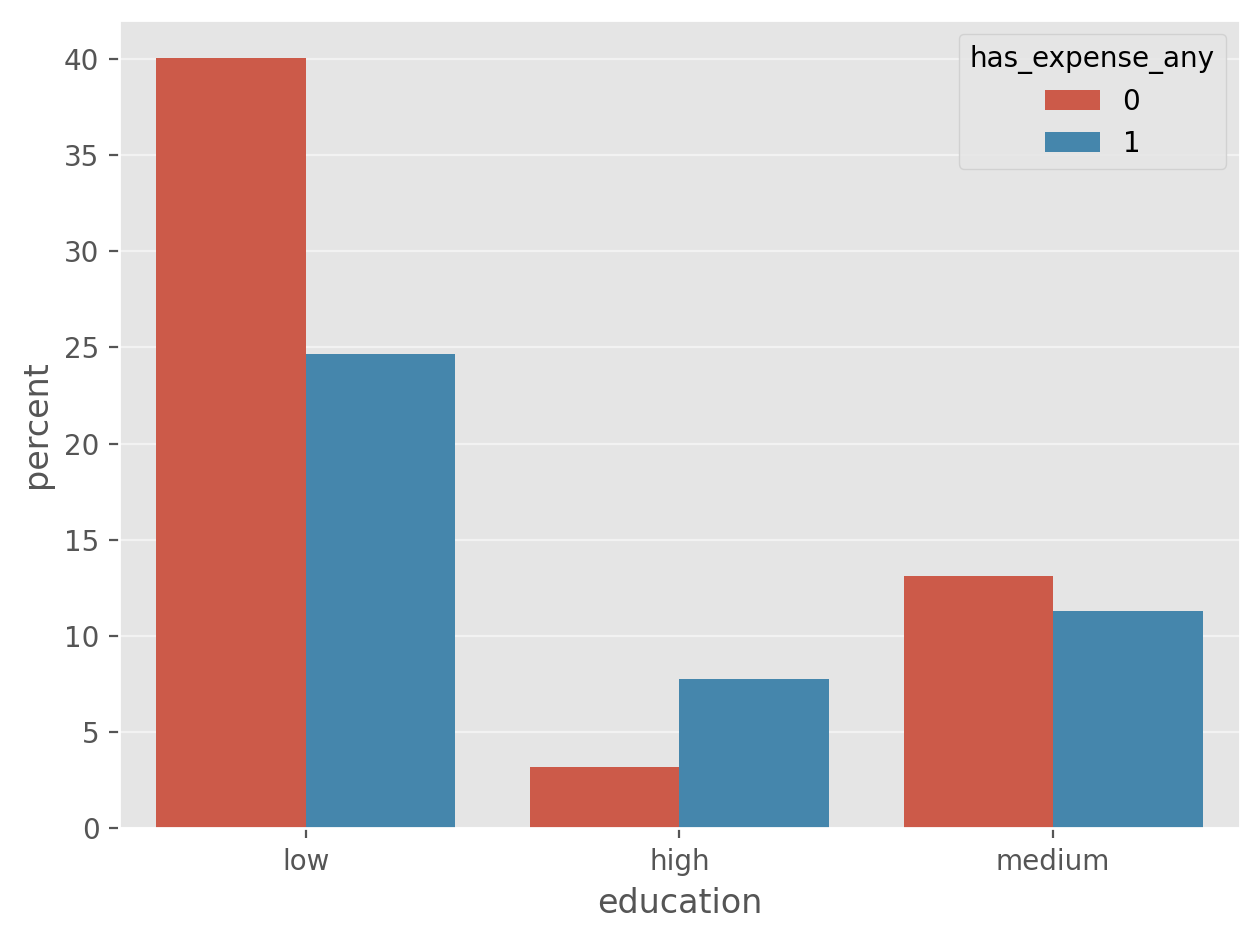

In [130]:
sns.countplot(df, x='education', hue='has_expense_any', stat='percent')

<Axes: xlabel='location_size', ylabel='percent'>

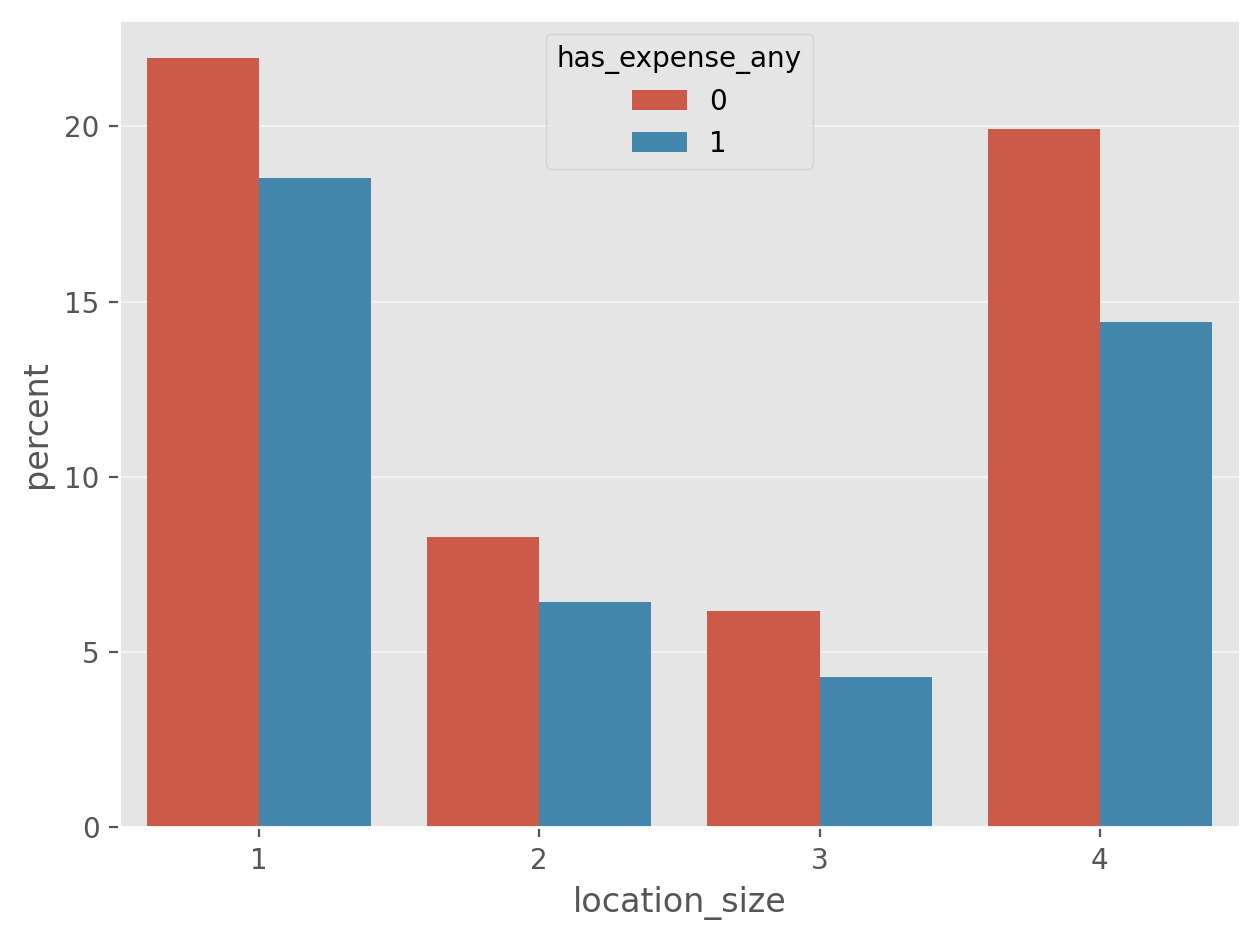

In [131]:
sns.countplot(df, x='location_size', hue='has_expense_any', stat='percent')

<Axes: xlabel='hh_size', ylabel='percent'>

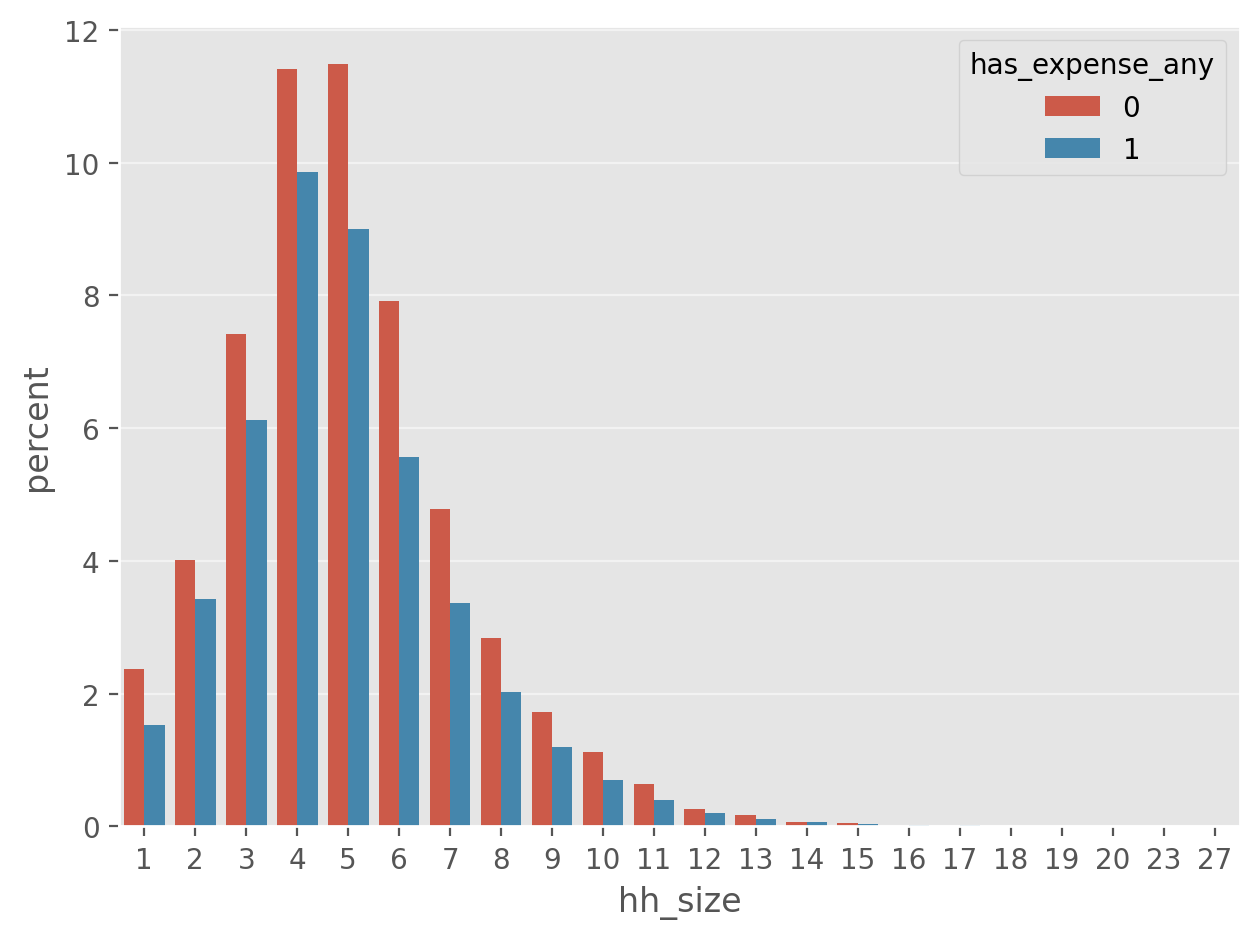

In [132]:
sns.countplot(df, x='hh_size', hue='has_expense_any', stat='percent')

<Axes: xlabel='count', ylabel='location'>

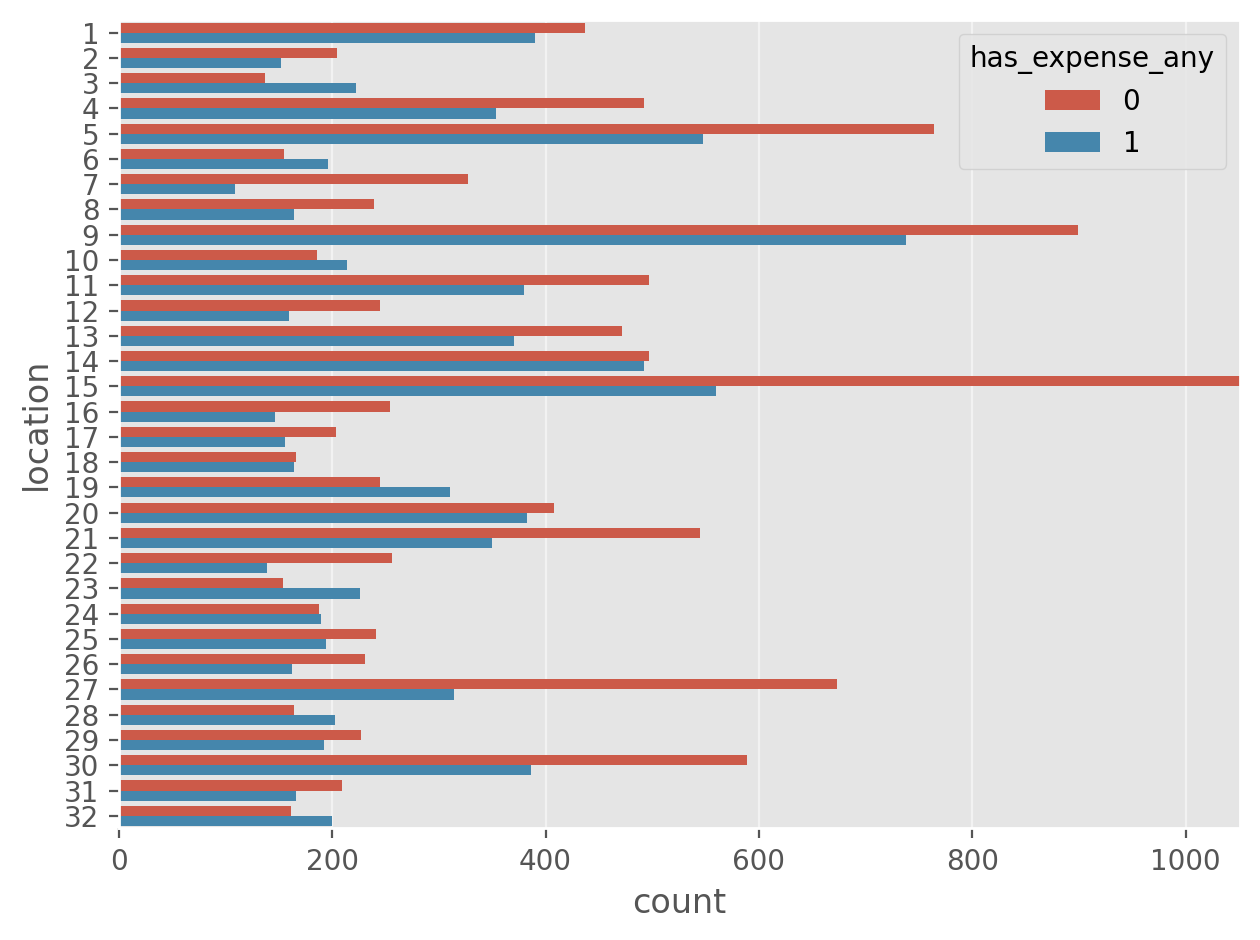

In [133]:
sns.countplot(df, y= 'location', hue='has_expense_any', orient='h')

<Axes: xlabel='has_expense_any', ylabel='age'>

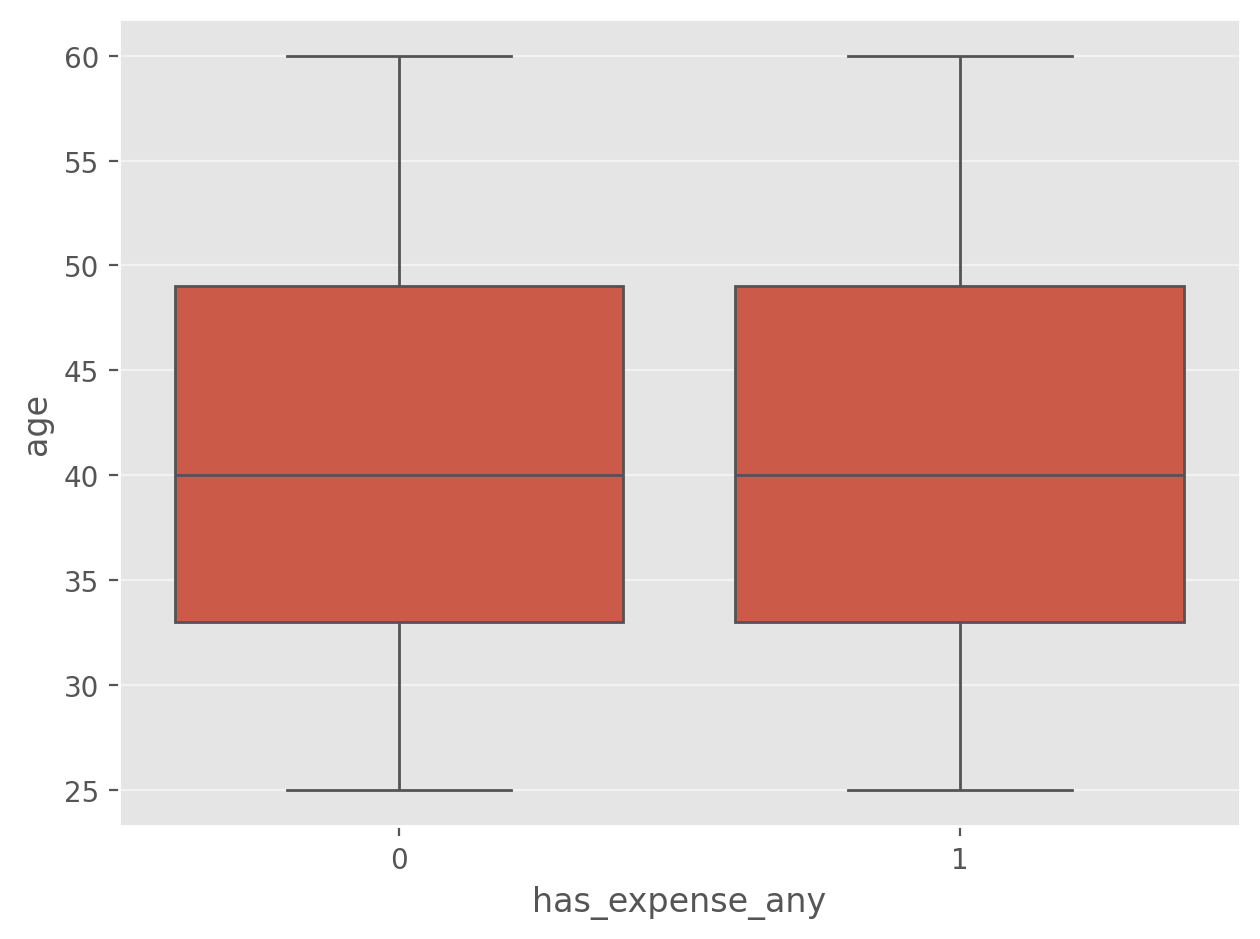

In [134]:
sns.boxplot(
    df, x='has_expense_any', y='age'
)

In [135]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import probit, identity
probit_model = sm.families.Binomial(probit()) # basic probit model
linear_model = sm.families.Gaussian(identity()) # basic linear model

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [136]:
y = 'has_expense_deposits_savings'
Z = '~ C(decile) + age + I(age**2) + C(education) + C(sex) + C(location_size)'
D = ' + C(Y)'

reg = y + Z + D

models = {}

models['deposits'] = smf.glm('has_expense_deposits_savings' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()
models['creditcard'] = smf.glm('has_expense_credit_card_payments' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()
models['has_expense_any'] = smf.glm('has_expense_any' + Z + D, df, missing='drop', freq_weights=df['weight'], family=probit_model).fit()

In [137]:
models['deposits'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                       
========================================================================================
Dep. Variable:     has_expense_deposits_savings   No. Observations:                20448
Model:                                      GLM   Df Residuals:                 30715670
Model Family:                          Binomial   Df Model:                           18
Link Function:                           probit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:            -1.7977e+07
Date:                          Tue, 09 Jan 2024   Deviance:                   3.5954e+07
Time:                                  21:24:29   Pearson chi2:                 3.07e+07
No. Iterations:                               6   Pseudo R-squ. (CS):              1.000
Covariance Type:                      nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.9945      0.005   -205.114      0.000      -1.004      -0.985
C(decile)[T.2]             0.1159      0.001     96.238      0.000       0.114       0.118
C(decile)[T.3]             0.2678      0.001    225.689      0.000       0.265       0.270
C(decile)[T.4]             0.2504      0.001    205.650      0.000       0.248       0.253
C(decile)[T.5]             0.5419      0.001    448.966      0.000       0.540       0.544
C(decile)[T.6]             0.5540      0.001    456.027      0.000       0.552       0.556
C(decile)[T.7]             0.6964      0.001    565.267      0.000       0.694       0.699
C(decile)[T.8]             0.9040      0.001    736.345      0.000       0.902       0.906
C(decile)[T.9]             1.0002      0.001    795.379      0.000       0.998       1.003
C(decile)[T.10]            1.3184      0.001    983.196      0.000       1.316       1.321
C(education)[T.low]        0.0056      0.001      6.270      0.000       0.004       0.007
C(education)[T.medium]    -0.0396      0.001    -46.692      0.000      -0.041      -0.038
C(sex)[T.Male]             0.1344      0.001    182.674      0.000       0.133       0.136
C(location_size)[T.2]      0.0764      0.001    103.006      0.000       0.075       0.078
C(location_size)[T.3]      0.1743      0.001    220.431      0.000       0.173       0.176
C(location_size)[T.4]      0.2486      0.001    331.840      0.000       0.247       0.250
C(Y)[T.1996]               0.0646      0.000    133.008      0.000       0.064       0.066
age                       -0.0086      0.000    -38.489      0.000      -0.009      -0.008
I(age ** 2)             2.356e-05   2.66e-06      8.869      0.000    1.84e-05    2.88e-05
==========================================================================================
"""

In [138]:
models['creditcard'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                         
============================================================================================
Dep. Variable:     has_expense_credit_card_payments   No. Observations:                20448
Model:                                          GLM   Df Residuals:                 30715670
Model Family:                              Binomial   Df Model:                           18
Link Function:                               probit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:            -5.7218e+06
Date:                              Tue, 09 Jan 2024   Deviance:                   1.1444e+07
Time:                                      21:24:29   Pearson chi2:                 4.61e+07
No. Iterations:                                  10   Pseudo R-squ. (CS):              1.000
Covariance Type:                          nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.5773      0.010   -481.748      0.000      -4.596      -4.559
C(decile)[T.2]            -0.1817      0.005    -33.874      0.000      -0.192      -0.171
C(decile)[T.3]            -0.0163      0.005     -3.476      0.001      -0.026      -0.007
C(decile)[T.4]             0.0206      0.005      4.516      0.000       0.012       0.029
C(decile)[T.5]             0.3267      0.004     77.333      0.000       0.318       0.335
C(decile)[T.6]             0.3459      0.004     83.052      0.000       0.338       0.354
C(decile)[T.7]             0.6146      0.004    150.488      0.000       0.607       0.623
C(decile)[T.8]             0.8070      0.004    200.247      0.000       0.799       0.815
C(decile)[T.9]             1.1546      0.004    288.662      0.000       1.147       1.162
C(decile)[T.10]            1.6989      0.004    423.636      0.000       1.691       1.707
C(education)[T.low]       -0.9602      0.001   -769.424      0.000      -0.963      -0.958
C(education)[T.medium]    -0.4961      0.001   -491.797      0.000      -0.498      -0.494
C(sex)[T.Male]             0.1891      0.001    148.918      0.000       0.187       0.192
C(location_size)[T.2]     -0.4151      0.001   -306.891      0.000      -0.418      -0.412
C(location_size)[T.3]     -0.6047      0.002   -312.599      0.000      -0.608      -0.601
C(location_size)[T.4]     -0.6025      0.002   -283.097      0.000      -0.607      -0.598
C(Y)[T.1996]              -0.2635      0.001   -317.569      0.000      -0.265      -0.262
age                        0.1395      0.000    338.061      0.000       0.139       0.140
I(age ** 2)               -0.0015    4.9e-06   -304.674      0.000      -0.002      -0.001
==========================================================================================
"""

In [139]:
models['has_expense_any'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        has_expense_any   No. Observations:                20448
Model:                            GLM   Df Residuals:                 30715670
Model Family:                Binomial   Df Model:                           18
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9038e+07
Date:                Tue, 09 Jan 2024   Deviance:                   3.8077e+07
Time:                        21:24:29   Pearson chi2:                 3.07e+07
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.4048      0.005   -295.305      0.000      -1.414      -1.395
C(decile)[T.2]             0.1155      0.001    105.086      0.000       0.113       0.118
C(decile)[T.3]             0.2413      0.001    220.181      0.000       0.239       0.243
C(decile)[T.4]             0.2271      0.001    201.936      0.000       0.225       0.229
C(decile)[T.5]             0.5049      0.001    446.651      0.000       0.503       0.507
C(decile)[T.6]             0.5220      0.001    458.678      0.000       0.520       0.524
C(decile)[T.7]             0.6836      0.001    589.177      0.000       0.681       0.686
C(decile)[T.8]             0.9232      0.001    791.290      0.000       0.921       0.925
C(decile)[T.9]             1.1728      0.001    968.698      0.000       1.170       1.175
C(decile)[T.10]            1.6108      0.001   1197.867      0.000       1.608       1.613
C(education)[T.low]       -0.2449      0.001   -269.895      0.000      -0.247      -0.243
C(education)[T.medium]    -0.2414      0.001   -276.308      0.000      -0.243      -0.240
C(sex)[T.Male]             0.2394      0.001    333.990      0.000       0.238       0.241
C(location_size)[T.2]      0.0852      0.001    117.281      0.000       0.084       0.087
C(location_size)[T.3]      0.2384      0.001    310.285      0.000       0.237       0.240
C(location_size)[T.4]      0.3743      0.001    517.718      0.000       0.373       0.376
C(Y)[T.1996]              -0.0105      0.000    -22.107      0.000      -0.011      -0.010
age                        0.0299      0.000    136.171      0.000       0.029       0.030
I(age ** 2)               -0.0004   2.59e-06   -148.158      0.000      -0.000      -0.000
==========================================================================================
"""

In [140]:
y = 'log_income'
Z = '~ age + I(age**2) + C(education) + C(sex) + C(location_size)'
D = ' + C(Y)'

reg = y + Z + D

income_model = smf.glm(reg, df, missing='drop', freq_weights=df['weight'], family=linear_model).fit()
df['log_income_residual'] = income_model.resid_working
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                20448
Model:                            GLM   Df Residuals:                 30715679
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                         0.60999
Method:                          IRLS   Log-Likelihood:            -3.5992e+07
Date:                Tue, 09 Jan 2024   Deviance:                   1.8736e+07
Time:                        21:24:29   Pearson chi2:                 1.87e+07
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.6125      0.003   2055.430      0.000       5.607       5.618
C(education)[T.low]       -1.3809      0.000  -3018.700      0.000      -1.382      -1.380
C(education)[T.medium]    -0.8172      0.000  -1717.729      0.000      -0.818      -0.816
C(sex)[T.Male]            -0.1000      0.000   -238.106      0.000      -0.101      -0.099
C(location_size)[T.2]     -0.2484      0.000   -578.595      0.000      -0.249      -0.248
C(location_size)[T.3]     -0.4669      0.000  -1041.221      0.000      -0.468      -0.466
C(location_size)[T.4]     -0.8656      0.000  -2225.776      0.000      -0.866      -0.865
C(Y)[T.1996]              -0.2951      0.000  -1045.269      0.000      -0.296      -0.295
age                       -0.0290      0.000   -222.282      0.000      -0.029      -0.029
I(age ** 2)                0.0005   1.54e-06    326.411      0.000       0.000       0.001
==========================================================================================
"""

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f69b01f4040> is currently using DataFrameGroupBy.sum. In a future version of pandas, th

Text(0, 0.5, 'Percent')

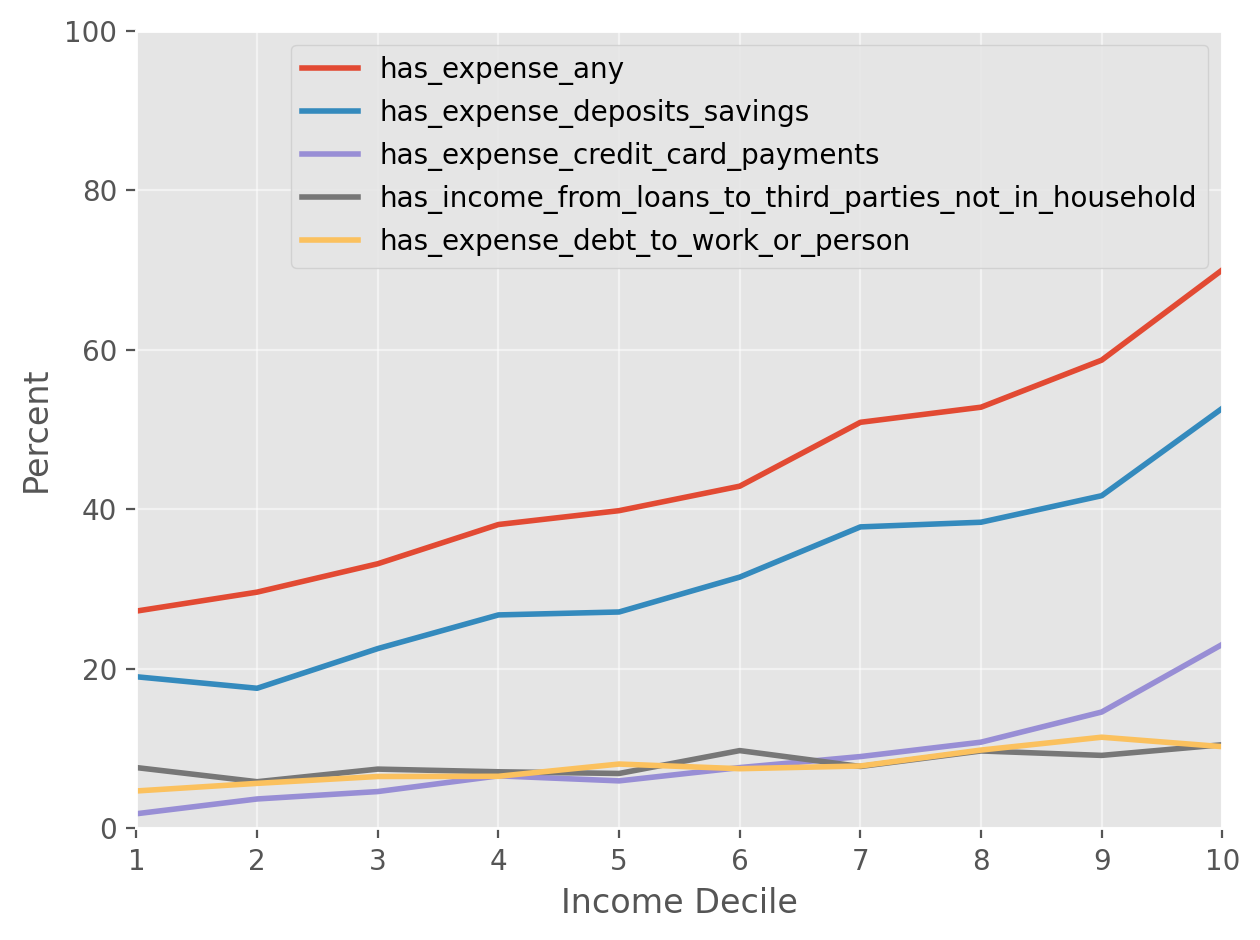

In [141]:
to_by_decile = ['has_expense_any',
                'has_expense_deposits_savings',
                'has_expense_credit_card_payments',
                'has_income_from_loans_to_third_parties_not_in_household',
                'has_expense_debt_to_work_or_person'
                ]

deciles = np.arange(1, 11)                

for x in to_by_decile:
    plt.plot(deciles, 100 * utils.indicator_by_decile(df, 'log_income_residual', x, 'weight'), label=x)
plt.legend()
plt.ylim(0, 100)
plt.xticks(np.arange(1, 11))

plt.xlabel('Income Decile')
plt.ylabel('Percent')

In [142]:
df['age_sq'] = df['age'] ** 2
C_education = pd.get_dummies(df['education'], prefix='education')
C_sex = pd.get_dummies(df['sex'], prefix='sex')
C_location_size = pd.get_dummies(df['location_size'], prefix='location_size')
C_Y = pd.get_dummies(df['Y'], prefix='Y')
C_decile = pd.get_dummies(df['decile'], prefix='decile')
C_location = pd.get_dummies(df['location'], prefix='location')

X_col = (['age', 'age_sq'] + list(C_education.columns) + list(C_sex.columns) + list(C_location_size.columns) +
         list(C_Y.columns) + list(C_decile.columns) + list(C_location.columns))
X_col = list(C_decile.columns)

df = pd.concat([df, C_education, C_sex, C_location_size, C_Y, C_location, C_decile], axis=1)

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

In [152]:
X = df[X_col]
Y = df['has_expense_any']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)
logit.fit(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight'])

LogisticRegression()

In [153]:
print(logit.score(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight']))
print(logit.score(X_test, Y_test, sample_weight=df.loc[X_test.index, 'weight']))
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(Y_test, logit.predict(X_test), 
                                      average='binary'))

0.652906475090036
0.668348332090817
(0.6581306017925737, 0.3890991672975019, 0.48905803996194097, None)


(0.0, 1.0)

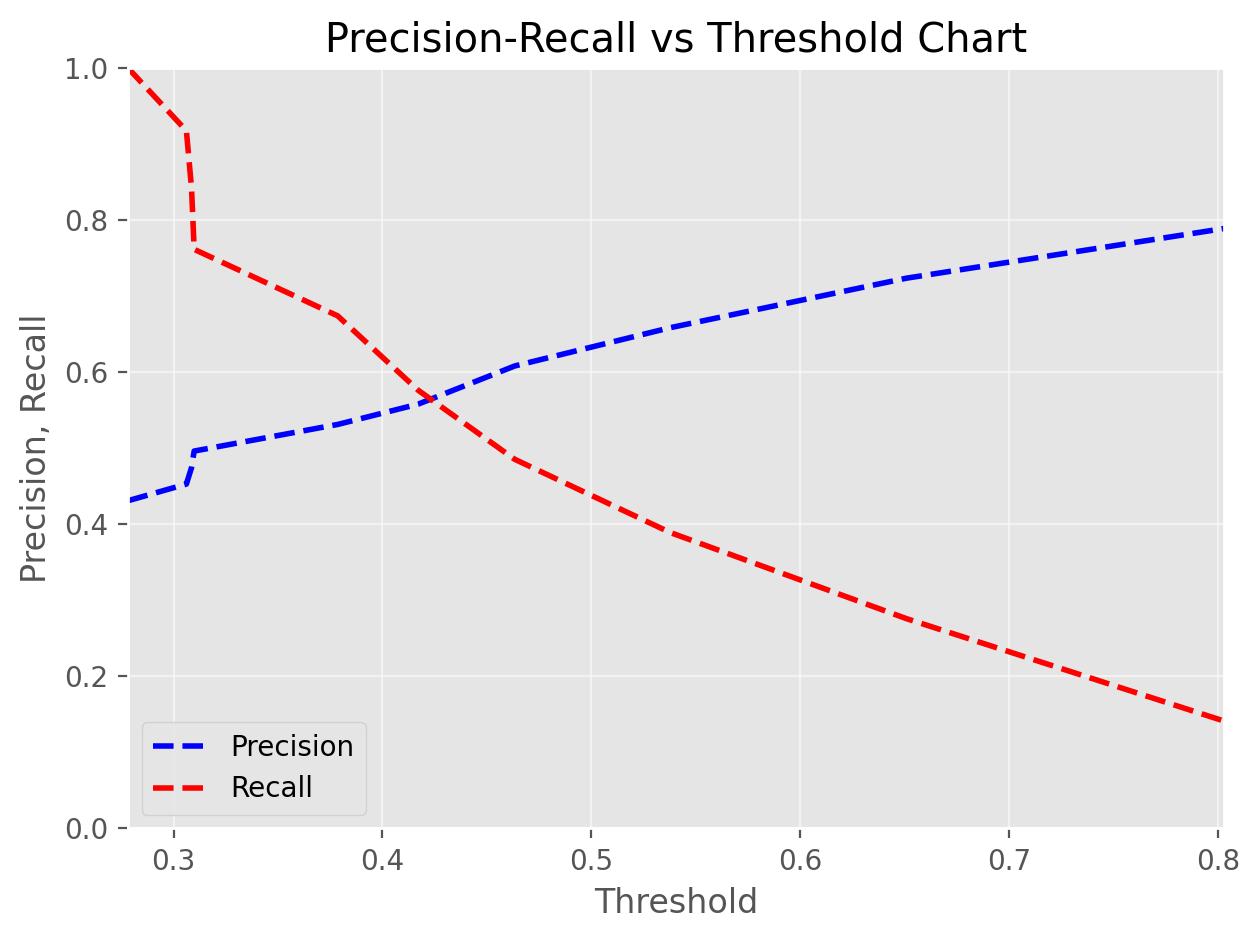

In [154]:
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_curve
Y_pred = logit.predict(X_test)
probs = logit.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(Y_test, probs[:, 1] )

pr_auc = sklearn.metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

<Axes: >

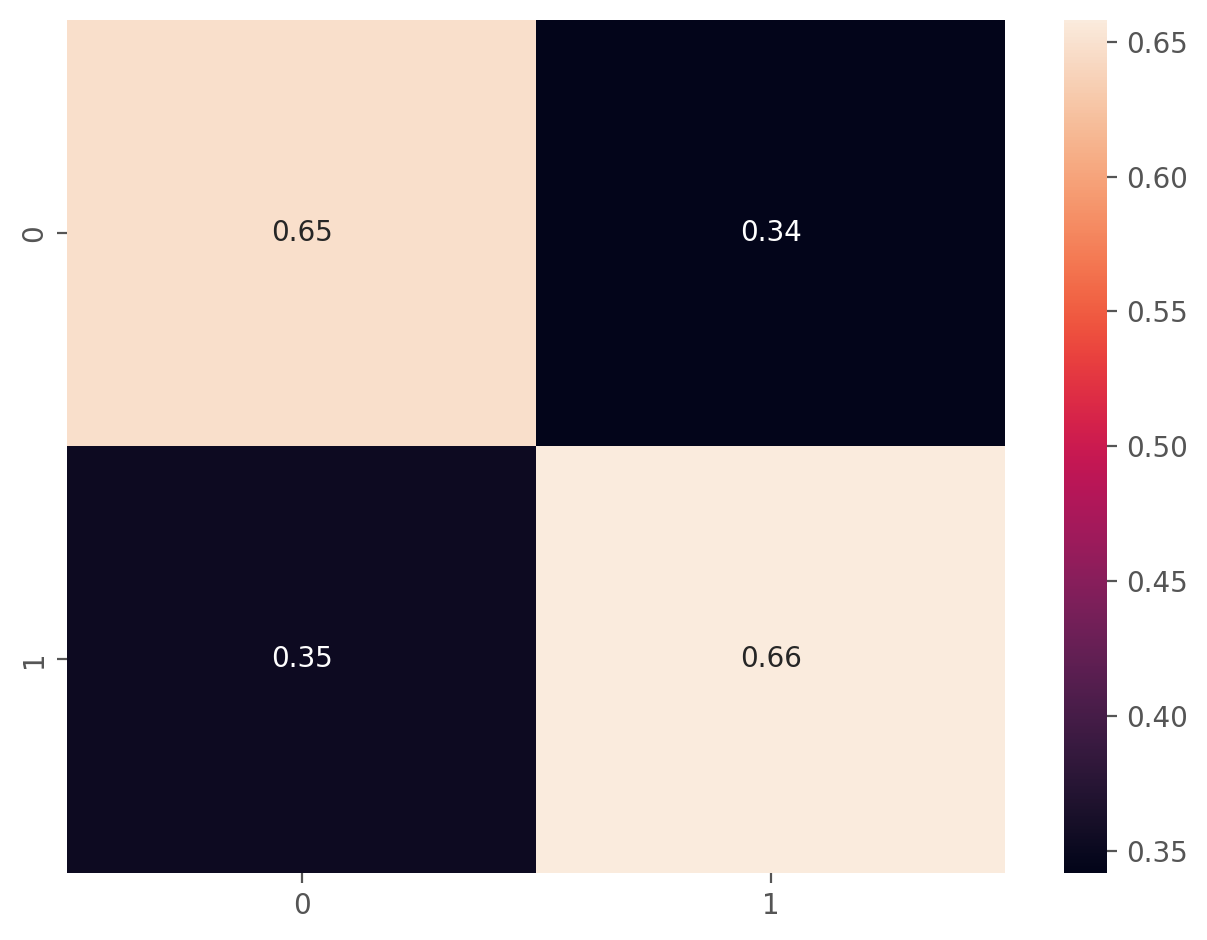

In [155]:
confusion = sklearn.metrics.confusion_matrix(Y_test, Y_pred, normalize='pred')
sns.heatmap(confusion, annot=True)

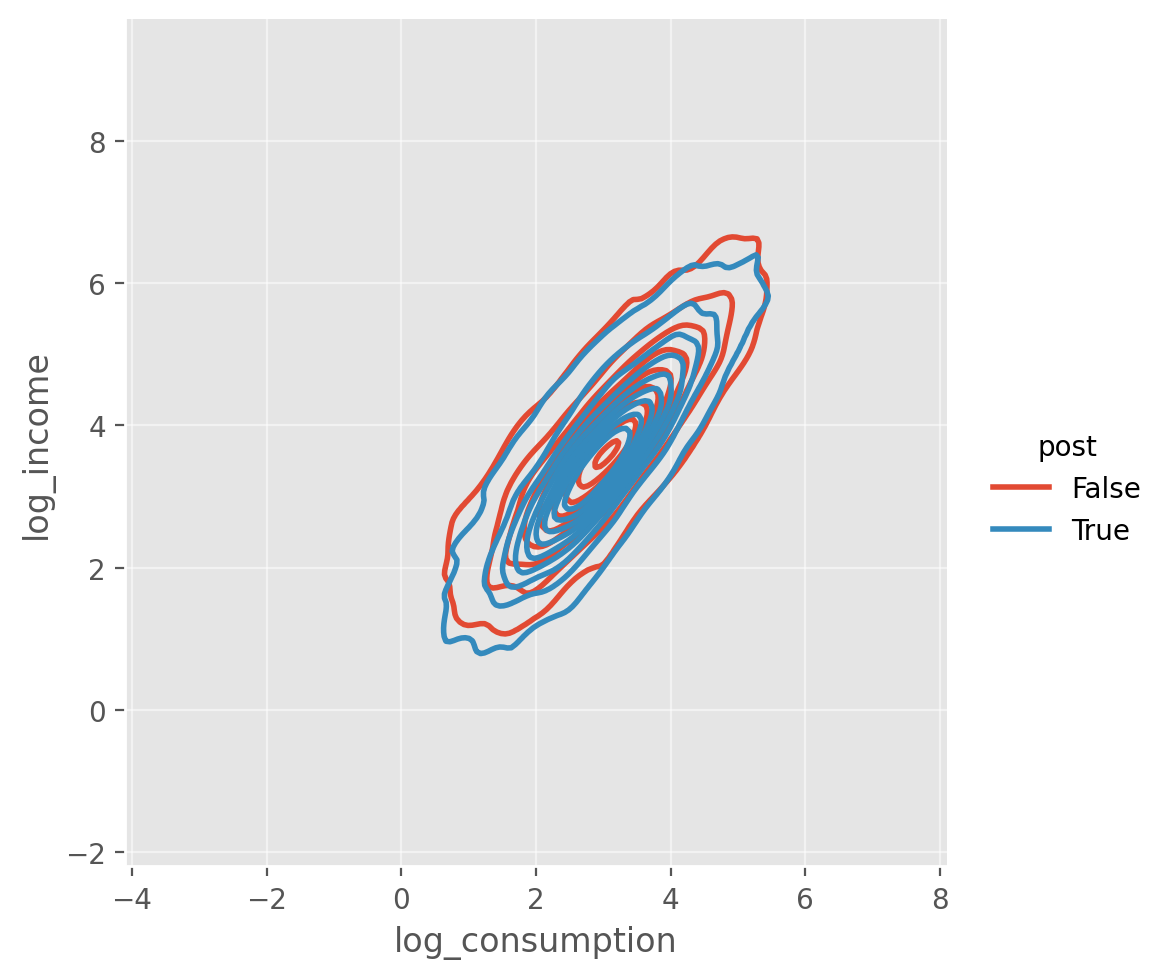

In [160]:
sns.displot(df, x='log_consumption', y='log_income', kind='kde', hue='post')

In [156]:
# turning this into something tangible: talk about introducing the 'threshold'
# selling this to people: using demographics as prediction mechanisms

In [190]:
aux = pd.crosstab(df.education, df.has_expense_deposits_savings, df.weight, aggfunc='sum', normalize='index')
aux

has_expense_deposits_savings,0.0,1.0
education,,
high,0.527562,0.472438
low,0.732653,0.267347
medium,0.657011,0.342989


In [194]:
aux = pd.crosstab(df.location_size, df.has_expense_any, df.weight, aggfunc='sum', normalize='index')
aux

has_expense_any,0,1
location_size,,
1,0.526152,0.473848
2,0.576324,0.423676
3,0.582553,0.417447
4,0.599119,0.400881


In [184]:
plt.bar()

sex,education,Female,Male
0,high,0.092456,0.907544
1,low,0.153798,0.846202
2,medium,0.113070,0.886930


In [178]:
aux.sum(axis=1)

education
high       4096294.0
low       18283254.0
medium     8336141.0
dtype: float64

In [157]:
df.groupby(['education'])['sex'].value_counts()

education  sex   
high       Male       2047
           Female      197
low        Male      11390
           Female     1829
medium     Male       4469
           Female      516
Name: count, dtype: int64